In [1]:
import os
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore", message=".*defaulting to pandas.*")
os.listdir()

['.DS_Store',
 '.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '.virtual_documents',
 'Asians.py',
 'bates.py',
 'bates_calibration_test.py',
 'contract_details',
 'data_query.py',
 'example_out.pdf',
 'historical_data',
 'horsing__around.py',
 'mlop.py',
 'old',
 'oneoff_calibration_testing.py',
 'plots',
 'plot_surface.py',
 'README.md',
 'routine_calibration_generation.py',
 'routine_calibration_global.py',
 'routine_calibration_testing.py',
 'term_structure',
 'testing.ipynb',
 'trained_models',
 'train_main.py',
 '__pycache__']

In [2]:
models_path = os.path.join(os.getcwd(),'trained_models')
models = os.listdir(models_path)
for i, path in enumerate(models):
    print(f"{i}   {path}")

0   2024_10_07 17-55-55 Deep Neural Network 3oosRMSE
1   2024_10_08 00-00-41 Deep Neural Network 3oosRMSE
2   2024_10_08 00-24-59 Deep Neural Network 3oosRMSE
3   2024_10_08 00-42-22 Deep Neural Network 3oosRMSE
4   2024_10_09 09-01-43 Deep Neural Network 6oosRMSE
5   2024_10_09 09-08-27 Deep Neural Network 9oosRMSE
6   2024_10_09 09-11-43 Deep Neural Network 11oosRMSE
7   2024_10_09 10-09-20 Deep Neural Network 15oosRMSE


In [3]:
model = models[0]
model

'2024_10_07 17-55-55 Deep Neural Network 3oosRMSE'

In [4]:
model_path = os.path.join(models_path,model)
model_path

'E:\\git\\machine-learning-option-pricing\\trained_models\\2024_10_07 17-55-55 Deep Neural Network 3oosRMSE'

In [5]:
model_files = os.listdir(model_path)
model_files

['.ipynb_checkpoints',
 '2024_10_07 17-55-55 Deep Neural Network 3oosRMSE insample_results.csv',
 '2024_10_07 17-55-55 Deep Neural Network 3oosRMSE outofsample_results.csv',
 '2024_10_07 17-55-55 Deep Neural Network 3oosRMSE.pkl',
 '2024_10_07 17-55-55 Deep Neural Network 3oosRMSE.txt']

In [6]:
spec_path = os.path.join(model_path,[file for file in model_files if file.endswith('.txt')][0])
spec_path

'E:\\git\\machine-learning-option-pricing\\trained_models\\2024_10_07 17-55-55 Deep Neural Network 3oosRMSE\\2024_10_07 17-55-55 Deep Neural Network 3oosRMSE.txt'

In [7]:
with open(spec_path, "r") as specs:
    for line in specs:
        print(line.strip())

Mon Oct  7 17:49:14 2024
spot(s):
[1311.13 1325.42 1330.53 1333.44 1338.73 1351.52 1372.91 1374.2  1377.99
1380.79 1386.77 1386.98 1387.16 1390.08 1391.82 1392.05 1395.15 1399.96
1401.2  1401.5  1401.77 1402.74 1403.05 1406.48 1406.58 1406.64 1406.77
1409.11 1409.82 1410.74 1411.59 1412.12 1412.71 1413.18 1414.71 1416.12
1416.34 1416.4  1416.59 1416.97 1418.28 1419.95 1420.46 1420.83 1422.42
1422.43 1423.07 1423.8  1424.27 1424.44 1426.09 1426.6  1428.02 1428.35
1428.7  1428.81 1430.36 1430.59 1430.69 1431.78 1433.18 1433.19 1433.55
1433.65 1434.56 1434.69 1436.11 1437.38 1437.45 1438.07 1438.45 1438.91
1438.99 1439.15 1439.53 1439.88 1439.97 1443.66 1444.24 1444.47 1445.28
1445.5  1445.71 1446.04 1446.9  1447.03 1447.04 1447.54 1447.77 1447.89
1448.38 1448.46 1449.6  1449.93 1451.21 1451.23 1451.6  1452.52 1452.78
1452.95 1452.96 1453.53 1453.85 1454.4  1454.47 1454.78 1455.05 1455.51
1456.3  1456.93 1457.51 1457.85 1458.35 1459.18 1459.53 1460.37 1462.63
1462.85 1463.59 1463.78 1466.

In [8]:
model_path

'E:\\git\\machine-learning-option-pricing\\trained_models\\2024_10_07 17-55-55 Deep Neural Network 3oosRMSE'

In [9]:
model_files

['.ipynb_checkpoints',
 '2024_10_07 17-55-55 Deep Neural Network 3oosRMSE insample_results.csv',
 '2024_10_07 17-55-55 Deep Neural Network 3oosRMSE outofsample_results.csv',
 '2024_10_07 17-55-55 Deep Neural Network 3oosRMSE.pkl',
 '2024_10_07 17-55-55 Deep Neural Network 3oosRMSE.txt']

In [10]:
insample_path = os.path.join(model_path,[file for file in model_files if file.find('insample') != -1][0])
insample = pd.read_csv(insample_path).iloc[:,1:]
insample

2024-10-09 10:40:18,129	INFO worker.py:1786 -- Started a local Ray instance.


,spot_price,strike_price,barrier,days_to_maturity,barrier_price,updown,outin,w,barrier_type_name,rebate,...,kappa,rho,eta,v0,calculation_date,expiration_date,observed_price,insample_target,insample_prediction,insample_error
0,1416.59,1274.931,708.295000,60,0.485092,Down,Out,put,DownOut,0.0,...,0.233438,-1.000000,0.098497,0.010662,2007-01-03,2007-03-04,0.343440,0.343440,-1.913399,-2.256839
1,1416.59,1274.931,881.827275,60,0.479647,Down,Out,put,DownOut,0.0,...,0.233438,-1.000000,0.098497,0.010662,2007-01-03,2007-03-04,0.171918,0.171918,-1.672056,-1.843974
2,1416.59,1274.931,1055.359550,60,0.475925,Down,Out,put,DownOut,0.0,...,0.233438,-1.000000,0.098497,0.010662,2007-01-03,2007-03-04,0.501203,0.501203,5.710405,5.209201
3,1416.59,1274.931,1228.891825,60,0.154411,Down,Out,put,DownOut,0.0,...,0.233438,-1.000000,0.098497,0.010662,2007-01-03,2007-03-04,0.119148,0.119148,3.362793,3.243644
4,1416.59,1274.931,1228.891825,60,0.319234,Down,In,put,DownIn,0.0,...,0.233438,-1.000000,0.098497,0.010662,2007-01-03,2007-03-04,0.453563,0.453563,-2.279947,-2.733510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440195,1330.53,1463.583,1995.795000,360,25.882998,Up,In,call,UpIn,0.0,...,4.818263,-0.992817,0.256956,0.080810,2008-01-25,2009-01-19,25.533824,25.533824,17.747666,-7.786158
2440196,1330.53,1463.583,1995.795000,540,46.827734,Up,Out,call,UpOut,0.0,...,4.818263,-0.992817,0.256956,0.080810,2008-01-25,2009-07-18,46.915021,46.915021,46.489333,-0.425688
2440197,1330.53,1463.583,1995.795000,540,62.054120,Up,In,call,UpIn,0.0,...,4.818263,-0.992817,0.256956,0.080810,2008-01-25,2009-07-18,62.009710,62.009710,58.712269,-3.297442
2440198,1330.53,1463.583,1995.795000,720,38.532601,Up,Out,call,UpOut,0.0,...,4.818263,-0.992817,0.256956,0.080810,2008-01-25,2010-01-14,38.458786,38.458786,32.321057,-6.137729


In [11]:
outsample_path = os.path.join(model_path,[file for file in model_files if file.find('outofsample') != -1][0])
outsample = pd.read_csv(outsample_path).iloc[:,1:]
outsample

,spot_price,strike_price,barrier,days_to_maturity,barrier_price,updown,outin,w,barrier_type_name,rebate,...,kappa,rho,eta,v0,calculation_date,expiration_date,observed_price,outofsample_target,outofsample_prediction,outofsample_error
0,1353.73,1218.357,676.865,60,11.944285,Down,Out,put,DownOut,0.0,...,4.276874,-0.99998,0.237840,0.068675,2008-01-28,2008-03-28,12.085354,12.085354,14.005431,1.920077
1,1353.73,1218.357,676.865,90,18.968786,Down,Out,put,DownOut,0.0,...,4.276874,-0.99998,0.237840,0.068675,2008-01-28,2008-04-27,19.084268,19.084268,17.418793,-1.665475
2,1353.73,1218.357,676.865,90,0.021951,Down,In,put,DownIn,0.0,...,4.276874,-0.99998,0.237840,0.068675,2008-01-28,2008-04-27,0.000000,0.000000,-1.494091,-1.494091
3,1353.73,1218.357,676.865,180,34.557329,Down,Out,put,DownOut,0.0,...,4.276874,-0.99998,0.237840,0.068675,2008-01-28,2008-07-26,34.378833,34.378833,36.503818,2.124984
4,1353.73,1218.357,676.865,180,1.008665,Down,In,put,DownIn,0.0,...,4.276874,-0.99998,0.237840,0.068675,2008-01-28,2008-07-26,0.648057,0.648057,1.610064,0.962007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347532,1293.41,1422.751,1940.115,360,17.401104,Up,In,call,UpIn,0.0,...,1.422458,-1.00000,0.185708,0.068024,2008-03-07,2009-03-02,17.564424,17.564424,9.133895,-8.430529
347533,1293.41,1422.751,1940.115,540,54.094556,Up,Out,call,UpOut,0.0,...,1.422458,-1.00000,0.185708,0.068024,2008-03-07,2009-08-29,53.949636,53.949636,54.144600,0.194964
347534,1293.41,1422.751,1940.115,540,49.920984,Up,In,call,UpIn,0.0,...,1.422458,-1.00000,0.185708,0.068024,2008-03-07,2009-08-29,49.888495,49.888495,44.300692,-5.587803
347535,1293.41,1422.751,1940.115,720,45.000306,Up,Out,call,UpOut,0.0,...,1.422458,-1.00000,0.185708,0.068024,2008-03-07,2010-02-25,45.450620,45.450620,43.433682,-2.016938


In [12]:
maturities = outsample['days_to_maturity'].unique().tolist()
barrier_type_names = outsample['barrier_type_name'].unique().tolist()
ws = outsample['w'].unique().tolist()
print(f"\nmaturities:\n{maturities}")
print(f"\ntypes:\n{barrier_type_names}\n{ws}\n")


maturities:
[60, 90, 180, 360, 540, 720]

types:
['DownOut', 'DownIn', 'UpOut', 'UpIn']
['put', 'call']



In [13]:
by_wbtypet = outsample.copy().set_index(['w','barrier_type_name','days_to_maturity'])

RMSE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        RMSE.loc[t,b] = np.sqrt(np.average((by_wbtypet.loc[(slice(None), b, t),'outofsample_error'])**2))
print(f"\nRMSE:\n{RMSE}")


MAE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        MAE.loc[t,b] = np.average(np.abs(by_wbtypet.loc[(slice(None), b, t),'outofsample_error']))
print(f"\nMAE:\n{MAE}")


RMSE:
      DownOut    DownIn     UpOut      UpIn
60   3.420546  3.036111  3.103050  1.928077
90   3.179918  2.553306  2.745966  2.956064
180  3.608048  2.932081  3.002232  2.531611
360  4.116093  3.474472  3.334166  3.491895
540  3.241166  3.421667  3.636143  3.934537
720  4.253463  4.654416  3.689636  4.757972

MAE:
      DownOut    DownIn     UpOut      UpIn
60   2.499641  2.045915  2.479627  1.334053
90   2.498592  1.813985  1.993175  1.801767
180  2.507377  2.259798  2.347951  1.733322
360  2.768824  2.386369  2.442526  2.596700
540  2.460775  2.422215  2.730204  3.035637
720  3.318341  3.597693  2.856043  3.685858


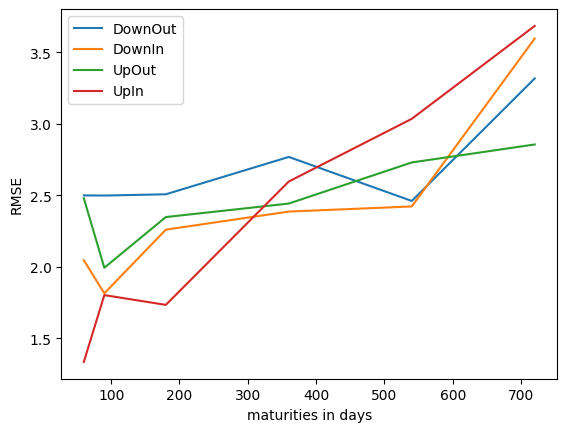

In [14]:
plt.figure()
plt.plot(MAE.loc[:, 'DownOut'], label='DownOut')
plt.plot(MAE.loc[:, 'DownIn'], label='DownIn')
plt.plot(MAE.loc[:, 'UpOut'], label='UpOut')
plt.plot(MAE.loc[:, 'UpIn'], label='UpIn')
plt.xlabel('maturities in days')
plt.ylabel('RMSE')
plt.legend()
plt.show()
plt.close()

In [24]:
print(f"\nmaturities:\n{maturities}")
print(f"\ntypes:\n{barrier_type_names}\n{ws}\n")


maturities:
[60, 90, 180, 360, 540, 720]

types:
['DownOut', 'DownIn', 'UpOut', 'UpIn']
['put', 'call']



In [25]:
for w in ws:
    print(w)

put
call


In [26]:
errors_bypayoff = {}
for w in ws:
    print(f"\n{w}s:"+f"\n{len(f"\n{w}s:")*'-'}")
    RMSE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        index = maturities,
        columns = barrier_type_names
        )
    for t in maturities:
        for b in barrier_type_names:
            RMSE.loc[t,b] = np.sqrt(np.average((by_wbtypet.loc[(w, b, t),'outofsample_error'])**2))
    print(f"RMSE:\n{RMSE}")
    RMSE = {'RMSE':RMSE}
    errors_bypayoff[w] = RMSE
    
    MAE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        index = maturities,
        columns = barrier_type_names
    )
    for t in maturities:
        for b in barrier_type_names:
            MAE.loc[t,b] = np.average(np.abs(by_wbtypet.loc[(w, b, t),'outofsample_error']))
    print(f"\nMAE:\n{MAE}")
    MAE = {'MAE':MAE}
    errors_bypayoff[w] = MAE


puts:
------
RMSE:
      DownOut    DownIn     UpOut      UpIn
60   4.359880  3.924620  3.422259  1.767015
90   3.495005  3.237743  2.292652  1.913713
180  4.741221  3.579366  2.724028  2.037415
360  5.399690  4.581928  2.862865  1.968799
540  3.495468  4.486368  3.776940  3.027768
720  4.892703  5.956835  3.682166  4.288410

MAE:
      DownOut    DownIn     UpOut      UpIn
60   3.346654  2.874963  2.881000  1.291842
90   2.769501  2.421115  1.700585  1.167625
180  3.445632  2.823775  2.263430  1.158740
360  3.709957  3.524338  2.118338  1.465069
540  2.482337  3.388721  2.898958  2.185357
720  3.703830  5.037204  2.883542  3.327668

calls:
-------
RMSE:
      DownOut    DownIn     UpOut      UpIn
60   2.250488  1.415974  2.708327  2.081774
90   2.863945  1.430979  3.171093  3.754456
180  2.104107  2.067502  3.281444  2.951271
360  2.418990  1.774782  3.785929  4.528852
540  2.991592  1.813317  3.474483  4.668382
720  3.575367  2.800587  3.697846  5.185185

MAE:
      DownOut    DownI

In [31]:
for key, value in errors_bypayoff.items():
    MAE = errors_bypayoff[key][']
    
    # MAE = errors
    # plt.figure()
    # plt.plot(MAE.loc[:, 'DownOut'], label='DownOut')
    # plt.plot(MAE.loc[:, 'DownIn'], label='DownIn')
    # plt.plot(MAE.loc[:, 'UpOut'], label='UpOut')
    # plt.plot(MAE.loc[:, 'UpIn'], label='UpIn')
    # plt.xlabel('maturities in days')
    # plt.ylabel('RMSE')
    # plt.legend()
    # plt.show()
    # plt.close()

put
{'MAE':       DownOut    DownIn     UpOut      UpIn
60   3.346654  2.874963  2.881000  1.291842
90   2.769501  2.421115  1.700585  1.167625
180  3.445632  2.823775  2.263430  1.158740
360  3.709957  3.524338  2.118338  1.465069
540  2.482337  3.388721  2.898958  2.185357
720  3.703830  5.037204  2.883542  3.327668}

call
{'MAE':       DownOut    DownIn     UpOut      UpIn
60   1.730624  1.079022  2.037607  1.377764
90   2.252608  1.129033  2.315411  2.471089
180  1.655441  1.681399  2.441035  2.318833
360  1.914275  1.248401  2.799560  3.728331
540  2.441197  1.455709  2.544352  3.885916
720  2.968318  2.158181  2.825759  4.044049}

